# Fine-tuning BERT and getting labeled comments

If you plan to fine-tune the BERT model, please use a GPU P100 or a better one 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!nvidia-smi

# Fine-tuning BERT Model

In this notebook, we fint-tune a pre-trained ERBT model and use the model to label comments with rating=3.0

In [ ]:
import pandas as pd 
import numpy as np 
# sklearn machine learning and measurements packages
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

# deep learning packages for bert
import torch
!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertModel, TrainingArguments, Trainer, pipeline
!pip install datasets
from datasets import load_metric, load_dataset

# visualization and standard library packages
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import heapq
from tqdm import tqdm
from collections import Counter

%matplotlib inline

RANDOM_STATE = 42
TEST_SIZE = 0.4

     |████████████████████████████████| 4.2 MB 26.2 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 596 kB 58.5 MB/s 
     |████████████████████████████████| 6.6 MB 55.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 342 kB 25.2 MB/s 
     |████████████████████████████████| 1.1 MB 38.9 MB/s 
     |████████████████████████████████| 212 kB 59.3 MB/s 
     |████████████████████████████████| 136 kB 78.7 MB/s 
     |████████████████████████████████| 127 kB 82.0 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 82.6 MB/s 
     |████████████████████████████████| 271 kB 78.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## Load Dataset & Exploration

For each movie, we have at most 320 comments. 

In [ ]:
comments = pd.read_csv('/content/drive/MyDrive/Dataset/moviedata-10m/comments.csv')
comments.columns

Index(['COMMENT_ID', 'USER_MD5', 'MOVIE_ID', 'CONTENT', 'VOTES',
       'COMMENT_TIME', 'RATING'],
      dtype='object')

In [ ]:
comments = comments.loc[:, ['COMMENT_TIME','MOVIE_ID', 'RATING', 'CONTENT', 'USER_MD5', 'VOTES']]
comments = comments.rename(columns={'COMMENT_TIME':'comment_time',
                                    'MOVIE_ID':'movie_id',
                                    'RATING':'rating',
                                    'CONTENT':'content',
                                   'USER_MD5':'user_md5',
                                   'VOTES':'votes'})

In [ ]:
# check empty content
empty_lst = []
error_lst = []
for index, row in tqdm(comments.iterrows()):
  try:
    if not row['content'].strip():
        empty_lst.append(index)
  except AttributeError:
    error_lst.append(index)
empty_lst, error_lst

4428475it [04:40, 15795.68it/s]


([190275,
  214925,
  396835,
  1537748,
  1922925,
  2146103,
  2583066,
  3101326,
  3770463],
 [2065335, 2875690])

In [ ]:
comments.drop(empty_lst + error_lst, axis=0, inplace=True)
comments = comments.reset_index(drop=True)
comments

,comment_time,movie_id,rating,content,user_md5,votes
0,2018-09-05 19:42:07,5113101,2.0,480p，画质不高，黑白，y,0ab7e3efacd56983f16503572d2b9915,0
1,2019-07-09 14:52:07,5113101,1.0,毫无看点，黑白画质，一个男人孤独的心理情景历程，疯疯癫癫，没有任何恐怖的成分，这应该是剧情片吧.,84dfd3f91dd85ea105bc74a4f0d7a067,0
2,2010-11-05 22:15:44,3718526,3.0,上吊那裡超好笑，可惜最後報告近況的旁白大扣分,c9a47fd59b55967ceac07cac6d5f270c,0
3,2010-06-20 02:12:50,3718526,NaN,上海国际电影节观摩片,35d3d5a52a7515c2ca6bb4d8e965149b,0
4,2011-04-09 22:10:13,3718526,NaN,！,54bfe88b57d8a3caea2637e62d182cf7,0
...,...,...,...,...,...,...
4428459,2018-07-08 17:48:09,26914297,5.0,歌舞精良，但是故事情节看的真是闹心。在时代的大背景下，谁都无法独善其身。,517cd1ba10c6bf42465184808ec80c1f,0
4428460,2017-01-03 17:55:35,26914297,4.0,麦金托什的25周年全部是视觉路线,9b03a9f6953b06611e3352a889ecdfa2,0
4428461,2018-12-10 20:09:20,26914297,3.0,记不住里面任何一首歌，就觉得胖女孩的胳膊记忆犹新,4f696ad30cec6601ca49dfc2281985f3,0
4428462,2019-08-03 14:39:02,26914297,4.0,故事不喜欢，但是场景精致，唱段好听。,9b32c4b5f73092083e23669ea6731b86,0


### Getting Labels

In [ ]:
def get_labels(comments):
  '''
  get labels for all comments.
  '''
  labels = []
  for x in tqdm(comments['rating']):
    if x in set((1.0, 2.0)):
      labels.append(0)
    elif x in set((4.0, 5.0)):
      labels.append(1)
    elif x in set((3.0,)):
      labels.append(-1)
    else:
      labels.append(-2)
  return labels

comments['label'] = get_labels(comments)
comments

100%|██████████| 4428464/4428464 [00:04<00:00, 977893.50it/s] 


,comment_time,movie_id,rating,content,user_md5,votes,label
0,2018-09-05 19:42:07,5113101,2.0,480p，画质不高，黑白，y,0ab7e3efacd56983f16503572d2b9915,0,0
1,2019-07-09 14:52:07,5113101,1.0,毫无看点，黑白画质，一个男人孤独的心理情景历程，疯疯癫癫，没有任何恐怖的成分，这应该是剧情片吧.,84dfd3f91dd85ea105bc74a4f0d7a067,0,0
2,2010-11-05 22:15:44,3718526,3.0,上吊那裡超好笑，可惜最後報告近況的旁白大扣分,c9a47fd59b55967ceac07cac6d5f270c,0,-1
3,2010-06-20 02:12:50,3718526,NaN,上海国际电影节观摩片,35d3d5a52a7515c2ca6bb4d8e965149b,0,-2
4,2011-04-09 22:10:13,3718526,NaN,！,54bfe88b57d8a3caea2637e62d182cf7,0,-2
...,...,...,...,...,...,...,...
4428459,2018-07-08 17:48:09,26914297,5.0,歌舞精良，但是故事情节看的真是闹心。在时代的大背景下，谁都无法独善其身。,517cd1ba10c6bf42465184808ec80c1f,0,1
4428460,2017-01-03 17:55:35,26914297,4.0,麦金托什的25周年全部是视觉路线,9b03a9f6953b06611e3352a889ecdfa2,0,1
4428461,2018-12-10 20:09:20,26914297,3.0,记不住里面任何一首歌，就觉得胖女孩的胳膊记忆犹新,4f696ad30cec6601ca49dfc2281985f3,0,-1
4428462,2019-08-03 14:39:02,26914297,4.0,故事不喜欢，但是场景精致，唱段好听。,9b32c4b5f73092083e23669ea6731b86,0,1


In [ ]:
Counter(comments['label'])

Counter({-2: 261765, -1: 1402891, 0: 847412, 1: 1916396})

In [ ]:
# comments = comments.reset_index()

In [ ]:
# we don't use to_csv() here is because simply use to_csv() would yield 
# wrongly formatted csv files.
def write_csv(example_df, file_dir):
  '''
  write example DataFrame into the given file directory 
  '''
  with open(file_dir, 'w') as f:
    writer = csv.writer(f, delimiter=',')
    # write column names 
    writer.writerow(('index',
                     'comment_time',
                     'movie_id',
                     'rating',
                     'content',
                     'user_md5',
                     'votes',
                     'label'))
    for idx, row in tqdm(example_df.iterrows()):
            writer.writerow((idx,
                             row['comment_time'],
                             row['movie_id'],
                             row['rating'],
                             row['content'],
                             row['user_md5'],
                             row['votes'],
                             row['label'],))

In [ ]:
# comments that don't have ratings or rating=3. This dataset could be used for prediction. 
comments_pred = comments[(comments['label'] == -1) | (comments['label'] == -2)].reset_index(drop=True)

file_pred = '/content/drive/MyDrive/Colab Notebooks/prediction_data.csv'

write_csv(comments_pred, file_pred)

1664656it [02:16, 12223.90it/s]


### Split train, evaluation, and test set

In this dataset, we use 500k positive and 500k negative commments for training

In [ ]:
# split the rest into train set and test set
train_test_comments = comments[(comments['label'] == 0) | (comments['label'] == 1)].reset_index(drop=True)
train_idx, test_idx = train_test_split(train_test_comments.index, 
                                       test_size=TEST_SIZE, 
                                       random_state=RANDOM_STATE)

In [ ]:
train_comments = train_test_comments.iloc[train_idx, :]
Counter(train_comments['label'])

Counter({0: 508264, 1: 1150020})

In [ ]:
test_comments = train_test_comments.iloc[test_idx, :]
Counter(test_comments['label'])

Counter({0: 339148, 1: 766376})

In [ ]:
test_comments = test_comments.reset_index(drop=True)
file_test = '/content/drive/MyDrive/Colab Notebooks/test_data_bert.csv'
write_csv(test_comments, file_test)

1105524it [01:39, 11109.16it/s]


In [ ]:
train_comments = train_comments.reset_index(drop=True)

In [ ]:
train_bert_idx, eval_bert_idx = train_test_split(train_comments.index, 
                                                 test_size=0.3, 
                                                 random_state=RANDOM_STATE)

In [ ]:
train_comments_bert = train_comments.iloc[train_bert_idx, :]
Counter(train_comments_bert['label'])

Counter({0: 356057, 1: 804741})

In [ ]:
eval_comments_bert = train_comments.iloc[eval_bert_idx, :]
Counter(eval_comments_bert['label'])

Counter({0: 152207, 1: 345279})

In [ ]:
train_comments_bert = train_comments_bert.reset_index(drop=True)
eval_comments_bert = eval_comments_bert.reset_index(drop=True)

In [ ]:
resampler = RandomUnderSampler()
train_comments_bert_resampled, _ = resampler.fit_resample(train_comments_bert, train_comments_bert['label'])

In [ ]:
Counter(train_comments_bert_resampled['label'])

Counter({0: 356057, 1: 356057})

In [ ]:
resampler = RandomUnderSampler()
eval_comments_bert_resampled, _ = resampler.fit_resample(eval_comments_bert, eval_comments_bert['label'])
Counter(eval_comments_bert_resampled['label'])

Counter({0: 152207, 1: 152207})

In [ ]:
file_train_bert = '/content/drive/MyDrive/Colab Notebooks/train_data_bert_resampled.csv'
file_eval_bert = '/content/drive/MyDrive/Colab Notebooks/eval_data_bert_resampled.csv'

write_csv(train_comments_bert_resampled, file_train_bert)
write_csv(eval_comments_bert_resampled, file_eval_bert)

712114it [01:01, 11506.23it/s]
304414it [00:26, 11549.39it/s]


## Train BERT model

The training code is from huggingface's official [Transformers tutorial](https://huggingface.co/docs/transformers/training#finetune-with-trainer).

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=2)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/393M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Check the number of comments that have a length of more than 128/256. 
The maximum length BERT can support is 512. However, a BERT model using max_length=512 is too large for Colab 

In [ ]:
len_128 = 0
len_256 = 0
for _, comment in tqdm(comments.iterrows()):
  try: 
    len_comment = len(comment['content'])
  except TypeError:
    len_comment = len(str(comment['content']))

  if len_comment > 128:
    len_128 += 1
  if len_comment > 256:
    len_256 += 1
      
len_128, len_256

In [ ]:
# we don't have enough cuda memory to train a model with max_lenght of 512.
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", max_length=256, truncation=True)

In [ ]:
dataset = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/Colab Notebooks/train_data_bert_resampled.csv',
                                          'test': '/content/drive/MyDrive/Colab Notebooks/eval_data_bert_resampled.csv'})
dataset = dataset.rename_column("content", "text")
dataset = dataset.remove_columns(['index', 'comment_time','movie_id', 'rating', 'user_md5', 'votes'])
dataset

Using custom data configuration default-99857e8e6624ca61


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-99857e8e6624ca61/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 712114
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 304414
    })
})

In [ ]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/713 [00:00<?, ?ba/s]

  0%|          | 0/305 [00:00<?, ?ba/s]

In [ ]:
train_dataset = tokenized_datasets["train"].shuffle(seed=RANDOM_STATE)
eval_dataset = tokenized_datasets["test"].shuffle(seed=RANDOM_STATE)

In [ ]:
# here we set batch_size=32 cause we have 24 hours time limit on Colab
# otherwise we need to resume from checkpoints many times!
training_args = TrainingArguments(output_dir="/content/drive/MyDrive/Colab Notebooks/output_bert", 
                                  num_train_epochs=2,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=64,
                                  save_strategy = "steps",
                                  save_steps = 10000,
                                  evaluation_strategy="epoch")
metric = load_metric("f1")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 712114
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 44508


Epoch,Training Loss,Validation Loss,F1
1,0.340000,0.324876,0.859300
2,0.283400,0.308420,0.867582


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/output_bert/checkpoint-10000
Configuration saved in /content/drive/MyDrive/Colab Notebooks/output_bert/checkpoint-10000/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/output_bert/checkpoint-10000/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/output_bert/checkpoint-20000
Configuration saved in /content/drive/MyDrive/Colab Notebooks/output_bert/checkpoint-20000/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/output_bert/checkpoint-20000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 304414
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/output_bert/checkpoint-30000
Configuration saved in /content/drive/MyDrive/Colab Notebooks/output_bert/checkpoint-30000/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/output_bert/checkpoint-30000/pytorch_model.bin
Saving

TrainOutput(global_step=44508, training_loss=0.33138479689998085, metrics={'train_runtime': 38654.604, 'train_samples_per_second': 36.845, 'train_steps_per_second': 1.151, 'total_flos': 1.8736506607663104e+17, 'train_loss': 0.33138479689998085, 'epoch': 2.0})

In [ ]:
# del model
# del trainer
# torch.cuda.empty_cache()

In [ ]:
model_dir = "/content/drive/MyDrive/Colab Notebooks/output_bert/model"
model.save_pretrained(model_dir)

Configuration saved in /content/drive/MyDrive/Colab Notebooks/output_bert/model/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/output_bert/model/pytorch_model.bin


## Test fine-tuned model

In [ ]:
model_dir = "/content/drive/MyDrive/Colab Notebooks/30200-balanced/output_bert/model"
model = AutoModelForSequenceClassification.from_pretrained(model_dir, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

In [ ]:
#set the model to cpu mode for evaluation
model = model.cpu()
text_classification = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [ ]:
def sentiment_analysis(example_df):
  '''
  Using fine-tuned bert  model to get 
  the sentiment label

  Inputs:
    test_comments:DataFrame

  Outputs:
    sentiment_label: list of sentiment labels
  '''
  sentiment_label = []
  scores = []
  # This operation would take a very long time, 
  # so we use tqdm to reduce our anxiery :)
  for comment in tqdm(example_df['content']):
      sent = text_classification(comment)[0]
      if sent['label'] == 'LABEL_0':
        sentiment_label.append(0)
      else:
        sentiment_label.append(1)
      scores.append(sent['score'])
  return sentiment_label, scores

In [ ]:
test_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_data_bert.csv')

In [ ]:
y_label, scores = sentiment_analysis(test_comments)

100%|██████████| 1105524/1105524 [19:09:48<00:00, 16.02it/s]


In [ ]:
test_comments['pred_label'] = y_label
test_comments['pred_score'] = scores

In [ ]:
# we don't use to_csv() here is because simply use to_csv() would yield 
# wrongly formatted csv files.
def write_csv_2(example_df, file_dir):
  '''
  write example DataFrame into the given file directory 
  '''
  with open(file_dir, 'w') as f:
    writer = csv.writer(f, delimiter=',')
    # write column names 
    writer.writerow(('index',
                     'comment_time',
                     'movie_id',
                     'rating',
                     'content',
                     'user_md5',
                     'votes',
                     'label',
                     'pred_label',
                     'pred_score'))
    for idx, row in tqdm(example_df.iterrows()):
            writer.writerow((idx,
                             row['comment_time'],
                             row['movie_id'],
                             row['rating'],
                             row['content'],
                             row['user_md5'],
                             row['votes'],
                             row['label'],
                             row['pred_label'],
                             row['pred_score']))

In [ ]:
file_test_pred = '/content/drive/MyDrive/Colab Notebooks/test_data_bert_pred.csv'
write_csv_2(test_comments, file_test_pred)

1105524it [01:37, 11360.94it/s]


In [ ]:
con_matrix_bert = confusion_matrix(test_comments['label'], y_label)
fig, ax = plt.subplots()
sns.heatmap(con_matrix_bert, annot=True, fmt='d',
            xticklabels=['negative', 'positive'], 
            yticklabels=['negative', 'positive'])
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title("Fine-tuned BERT Confusion Matrix")
fig.savefig('/content/drive/MyDrive/Colab Notebooks/BERT_confusion_matrix.png')

**Matthews correlation**

According to [sklearn's introduction](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), Matthews correlation coefficient could be used as a measure of the quality of classification even if the dataset is unbalanced. It ranges from -1 to 1, where 1 means perfect prediction.

Equation: 
$$ 
    MCC = \frac{TP*TN -FP*FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}
$$

In [ ]:
matthews_corrcoef(test_comments['label'], y_label)

0.7104864067779879

## Use Fine-tuned model for prediction

In [ ]:
pred_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/prediction_data.csv')
pred_comments

,index,comment_time,movie_id,rating,content,user_md5,votes,label
0,0,2010-11-05 22:15:44,3718526,3.0,上吊那裡超好笑，可惜最後報告近況的旁白大扣分,c9a47fd59b55967ceac07cac6d5f270c,0,-1
1,1,2010-06-20 02:12:50,3718526,NaN,上海国际电影节观摩片,35d3d5a52a7515c2ca6bb4d8e965149b,0,-2
2,2,2011-04-09 22:10:13,3718526,NaN,！,54bfe88b57d8a3caea2637e62d182cf7,0,-2
3,3,2014-04-19 01:30:48,10514820,3.0,连这个竟然都看了...,86dd268419a02513163814b3650e4cac,1,-1
4,4,2012-09-22 12:52:36,10514820,3.0,我不知道那时候为什么看了这么多香港口水片……,93ce30280bf1b116041a721906a2f64f,5,-1
...,...,...,...,...,...,...,...,...
1199995,1199995,2011-12-27 00:41:24,1839626,3.0,节奏感还行 一开始就主题鲜明 不停地死去 很大很美的圣诞夜 如花般的年纪一个个都被挖去眼睛 ...,10dfaed38a4cb4f16bddb241c1d91dde,0,-1
1199996,1199996,2019-08-07 20:10:21,4074745,3.0,当年是个炎炎夏日 我看着都觉得冷,26cc228741ed5382684eec3cc335e5a3,0,-1
1199997,1199997,2016-12-27 13:31:34,4074745,3.0,在哔哩哔哩看ccav6的国语配音片…醉了,bc465737e11cfd903811542c798a4e30,0,-1
1199998,1199998,2016-09-17 15:54:09,4074745,3.0,大灾大难面前人性的充分体现～,0b5979576917723e39527295db63e583,0,-1


In [ ]:
y_label_pred, scores_pred = sentiment_analysis(pred_comments)

In [ ]:
pred_comments['pred_label'] = y_label_pred
pred_comments['pred_score'] = scores_pred

In [ ]:
pred_comments

,index,comment_time,movie_id,rating,content,user_md5,votes,label,pred_label,pred_score
0,0,2010-11-05 22:15:44,3718526,3.0,上吊那裡超好笑，可惜最後報告近況的旁白大扣分,c9a47fd59b55967ceac07cac6d5f270c,0,-1,1,0.639989
1,1,2010-06-20 02:12:50,3718526,NaN,上海国际电影节观摩片,35d3d5a52a7515c2ca6bb4d8e965149b,0,-2,0,0.844157
2,2,2011-04-09 22:10:13,3718526,NaN,！,54bfe88b57d8a3caea2637e62d182cf7,0,-2,1,0.786296
3,3,2014-04-19 01:30:48,10514820,3.0,连这个竟然都看了...,86dd268419a02513163814b3650e4cac,1,-1,0,0.913975
4,4,2012-09-22 12:52:36,10514820,3.0,我不知道那时候为什么看了这么多香港口水片……,93ce30280bf1b116041a721906a2f64f,5,-1,0,0.853339
...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,2011-12-27 00:41:24,1839626,3.0,节奏感还行 一开始就主题鲜明 不停地死去 很大很美的圣诞夜 如花般的年纪一个个都被挖去眼睛 ...,10dfaed38a4cb4f16bddb241c1d91dde,0,-1,0,0.612386
1199996,1199996,2019-08-07 20:10:21,4074745,3.0,当年是个炎炎夏日 我看着都觉得冷,26cc228741ed5382684eec3cc335e5a3,0,-1,1,0.833923
1199997,1199997,2016-12-27 13:31:34,4074745,3.0,在哔哩哔哩看ccav6的国语配音片…醉了,bc465737e11cfd903811542c798a4e30,0,-1,0,0.966320
1199998,1199998,2016-09-17 15:54:09,4074745,3.0,大灾大难面前人性的充分体现～,0b5979576917723e39527295db63e583,0,-1,1,0.961547


In [ ]:
file_pred = '/content/drive/MyDrive/Colab Notebooks/prediction_data_predicted.csv'

write_csv_2(pred_comments, file_pred)

1200000it [01:46, 11266.70it/s]


## Manual checking

1000 comments from prediction set and 1000 comments from testing set

In [ ]:
file_pred = '/content/drive/MyDrive/Colab Notebooks/30200-balanced/prediction_data_predicted.csv'
pred_comments = pd.read_csv(file_pred)
pred_comments

,index,comment_time,movie_id,rating,content,user_md5,votes,label,pred_label,pred_score
0,0,2010-11-05 22:15:44,3718526,3.0,上吊那裡超好笑，可惜最後報告近況的旁白大扣分,c9a47fd59b55967ceac07cac6d5f270c,0,-1,1,0.639989
1,1,2010-06-20 02:12:50,3718526,NaN,上海国际电影节观摩片,35d3d5a52a7515c2ca6bb4d8e965149b,0,-2,0,0.844157
2,2,2011-04-09 22:10:13,3718526,NaN,！,54bfe88b57d8a3caea2637e62d182cf7,0,-2,1,0.786296
3,3,2014-04-19 01:30:48,10514820,3.0,连这个竟然都看了...,86dd268419a02513163814b3650e4cac,1,-1,0,0.913975
4,4,2012-09-22 12:52:36,10514820,3.0,我不知道那时候为什么看了这么多香港口水片……,93ce30280bf1b116041a721906a2f64f,5,-1,0,0.853339
...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,2011-12-27 00:41:24,1839626,3.0,节奏感还行 一开始就主题鲜明 不停地死去 很大很美的圣诞夜 如花般的年纪一个个都被挖去眼睛 ...,10dfaed38a4cb4f16bddb241c1d91dde,0,-1,0,0.612386
1199996,1199996,2019-08-07 20:10:21,4074745,3.0,当年是个炎炎夏日 我看着都觉得冷,26cc228741ed5382684eec3cc335e5a3,0,-1,1,0.833923
1199997,1199997,2016-12-27 13:31:34,4074745,3.0,在哔哩哔哩看ccav6的国语配音片…醉了,bc465737e11cfd903811542c798a4e30,0,-1,0,0.966320
1199998,1199998,2016-09-17 15:54:09,4074745,3.0,大灾大难面前人性的充分体现～,0b5979576917723e39527295db63e583,0,-1,1,0.961547


In [ ]:
pred_sampled = pred_comments.sample(1000, random_state=RANDOM_STATE)
pred_sampled.head(20)

,index,comment_time,movie_id,rating,content,user_md5,votes,label,pred_label,pred_score
372605,372605,2012-08-06 09:28:18,1295570,3.0,宝岛一号，天安门一号。香港电影最大的本领就是，任何娱乐片也能捎上政治。,fe024468f1ffe636d2a6b1a874ff115b,0,-1,0,0.582680
551204,551204,2018-07-14 00:33:27,2124737,NaN,无法评分 我也不知道为什么会去电影院看这样的电影（2007.08.31,fa97835e35e00b0656796a4ec0944f12,0,-2,0,0.963966
240320,240320,2019-02-27 13:57:23,27156513,3.0,导演基本可以认定为印度版陈凯歌了，专门弄形式大于内容的东西出来。,10499dc40243c38fca9c9359e8e0221e,2,-1,0,0.963404
1047361,1047361,2014-07-12 13:40:06,10766475,3.0,擦 内涵...,c75401ea087d8e2a831169edfb07bd66,0,-1,0,0.960833
555362,555362,2016-11-23 20:28:03,20516903,3.0,画面太美～太可怕了～,34db1688fe4fe0018457115c16850860,0,-1,1,0.962594
1062538,1062538,2019-08-24 18:21:47,26811449,3.0,一般般，看着乐呵,1d09b3d588e7d77d3181d80cb8e548b8,0,-1,0,0.943481
552662,552662,2013-02-07 21:05:34,1959877,3.0,失望，不如宫崎骏之前的电影有创意！,750e0ea91b98e4fad7b9f6aac2ff1523,2,-1,0,0.996510
1021194,1021194,2014-02-26 18:12:25,19967839,3.0,很清新 但感觉就是加长版的广告 自始至终我都没有一丝一毫是在看电影的感觉……,808e4a7fee0221225bee3022ac7fd259,0,-1,1,0.738198
886200,886200,2010-05-30 22:57:08,1759849,3.0,俄国佬阴险狡诈打不死，但是讲信用。。。,dffdfb07b14c03bff496472129b1a76c,0,-1,1,0.662285
609792,609792,2018-02-14 11:59:58,26703793,3.0,不是很喜欢女主的声音,ba485a66e59f343f27d63e1a8be980de,0,-1,0,0.723370


In [ ]:
writer = pd.ExcelWriter("/content/drive/MyDrive/Colab Notebooks/30200-balanced/prediction.xlsx")
pred_sampled.to_excel(writer, "sheet1")
writer.save()

In [ ]:
file_test = '/content/drive/MyDrive/Colab Notebooks/30200-balanced/test_data_bert_pred.csv'
test_comments = pd.read_csv(file_test)
test_comments

,index,comment_time,movie_id,rating,content,user_md5,votes,label,pred_label,pred_score
0,0,2018-02-11 00:45:02,5193976,2.0,烂,6420199316990972037517f93b45c17e,0,0,0,0.997694
1,1,2019-06-25 22:10:08,3006781,5.0,这电影已经拍的更细致了啊。比如狗的咬伤......,be93d57cbc7559c56d637894041aec5b,0,1,1,0.919366
2,2,2015-03-21 12:45:27,21770915,4.0,经常说老夫少妻是一支笑柄，但经过三个半小时，艾登在风中飘零的微笑，尼哈尔透过窗子的凝视似乎让...,4185838a2e1bed049803feb69167c416,3,1,1,0.990834
3,3,2017-01-01 20:38:15,3868141,4.0,呜呜呜呜呜难看的驯鹿毛衣一出现我就哭成了一个傻逼。ottolenghi大法好！,03a67d751b45de0b6333823f040b655e,27,1,1,0.644347
4,4,2019-08-22 18:25:19,6110546,4.0,看到达西夫妇同框的时候还是很感慨的，很喜欢每一幕的切换,d848ff05128a830d63b98001079bda73,0,1,1,0.994390
...,...,...,...,...,...,...,...,...,...,...
1105519,1105519,2015-08-19 10:43:45,26365745,1.0,乐佩的脸和发型爱丽儿的红发哈哈哈导演炸了,df022d02eddfdb6afb69c67a7b2fadac,1,0,1,0.512613
1105520,1105520,2019-05-07 09:56:41,1306983,2.0,当时看就觉得有点莫名其妙…,3379e7dc7fd942b3ace54c8d0c8d2464,0,0,0,0.843194
1105521,1105521,2018-05-06 00:30:57,2352020,5.0,孤独像大海，有时潮起，有时潮落，可拍打的浪头从不停止。,04c9df4d8147d0a5c82f2347c542b9a2,0,1,1,0.969815
1105522,1105522,2016-06-04 22:00:40,1301770,4.0,老布很叼啊,47b15121a034751337e199336ea73cf7,0,1,1,0.882840


In [ ]:
test_sampled = test_comments.sample(1000, random_state=RANDOM_STATE)
test_sampled.head(20)

,index,comment_time,movie_id,rating,content,user_md5,votes,label,pred_label,pred_score
985420,985420,2012-08-31 21:00:05,4833574,4.0,钟爱苗圃。,84d79f55ac23ac38f216c82425c4c388,0,1,1,0.909387
119195,119195,2011-04-13 00:26:32,3015835,4.0,爱人讲Timing，做正选是时机，做后备是命运。受伤=无意识的成长。女人说的永远和心里想的不...,52d2e35666fade137fba760284122bac,0,1,1,0.941245
1065229,1065229,2015-12-23 19:59:54,25881247,4.0,非常老套的故事，女主没写好故事有点散前半有点虚张声势。法律无法生存的混乱边境里被复仇吞噬的一...,f6d307c347f6950e7c1983f0050791c5,0,1,1,0.936880
678000,678000,2019-05-29 22:55:04,30426860,4.0,掸脏胆抉,b1d3a31a1929c1cdf2592fce9b186af1,0,1,0,0.526458
782689,782689,2019-09-03 16:26:03,2149806,4.0,逝去并不是终结，而是超越，走向下一程。至亲的生离死别，每个人终将会经历，被留下的人是很痛苦的...,5bc08b3ec00636eca2ca46b5fbb39f26,0,1,1,0.995316
739191,739191,2013-02-22 15:48:49,20378849,5.0,二黄二黄！！,528a37c8a5eb366f293d322ff4b58b5f,0,1,1,0.662392
418948,418948,2012-02-18 01:53:21,1421927,5.0,如果说从1996这时开始起，黄生就演自己写的剧本多好，总没有那么多完美的事情。电影很棒，人物...,a7618b3f997ed0710db7159b8d5880a7,0,1,1,0.994640
794623,794623,2016-04-10 18:11:23,26364085,2.0,真是物以类聚，人以群分啊。,96a5c72212f5cd55c8af92bc36b8e6a7,0,0,1,0.681176
138312,138312,2010-08-15 14:23:12,3324578,4.0,did i have my best summer?,c3c3f63ca2e6b84a53b8cbb08d25de68,0,1,1,0.832647
602833,602833,2018-07-21 18:15:19,3914547,4.0,为小警长打call,74611ed5e9f020afd4115a5a4cf922d3,0,1,1,0.977524


In [ ]:
writer = pd.ExcelWriter("/content/drive/MyDrive/Colab Notebooks/30200-balanced/test.xlsx")
test_sampled.to_excel(writer, "sheet1")
writer.save()

Comparting predicted results with labels  from human checkers

In [ ]:
test_sample = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/30200-balanced/test.xlsx")
pred_sample = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/30200-balanced/prediction.xlsx")

In [ ]:
test_sample

,Unnamed: 0,index,comment_time,movie_id,rating,content,user_md5,votes,label,pred_label,pred_score,human checker
0,985420.0,985420.0,2012-08-31 21:00:05,4833574.0,4.0,钟爱苗圃。,84d79f55ac23ac38f216c82425c4c388,0.0,1.0,1.0,0.909387,1.0
1,119195.0,119195.0,2011-04-13 00:26:32,3015835.0,4.0,爱人讲Timing，做正选是时机，做后备是命运。受伤=无意识的成长。女人说的永远和心里想的不...,52d2e35666fade137fba760284122bac,0.0,1.0,1.0,0.941245,1.0
2,1065229.0,1065229.0,2015-12-23 19:59:54,25881247.0,4.0,非常老套的故事，女主没写好故事有点散前半有点虚张声势。法律无法生存的混乱边境里被复仇吞噬的一...,f6d307c347f6950e7c1983f0050791c5,0.0,1.0,1.0,0.936880,1.0
3,678000.0,678000.0,2019-05-29 22:55:04,30426860.0,4.0,掸脏胆抉,b1d3a31a1929c1cdf2592fce9b186af1,0.0,1.0,0.0,0.526458,0.0
4,782689.0,782689.0,2019-09-03 16:26:03,2149806.0,4.0,逝去并不是终结，而是超越，走向下一程。至亲的生离死别，每个人终将会经历，被留下的人是很痛苦的...,5bc08b3ec00636eca2ca46b5fbb39f26,0.0,1.0,1.0,0.995316,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,36953.0,36953.0,2017-09-09 21:51:26,26800974.0,4.0,电影还可以啊，为什么评分这么低。。。。就是最后男主的名牌，那个镜头实在是太暗了，我看不清男主...,b63d66fcd15b8665bc63c72076ddbcdc,0.0,1.0,1.0,0.976083,1.0
996,17077.0,17077.0,2019-02-05 21:57:11,6001038.0,4.0,温情治愈 不忘初心 要为村庄带去光明啊！,39dc7d566cf9fab2c8fc807f2b08a832,0.0,1.0,1.0,0.996959,1.0
997,369019.0,369019.0,2016-01-02 23:07:24,1428119.0,2.0,2016第二部，芙芙。,b076f6c5d5aa95d016a9597ee96d4600,0.0,0.0,1.0,0.694732,0.0
998,256697.0,256697.0,2015-03-12 19:43:59,6005532.0,5.0,看看,0708454bca03af66be6c4da68d4543dc,0.0,1.0,1.0,0.872747,0.0


In [ ]:
pred_sample

,Unnamed: 0,index,comment_time,movie_id,rating,content,user_md5,votes,label,pred_label,pred_score,human checker
0,372605.0,372605.0,2012-08-06 09:28:18,1295570.0,3.0,宝岛一号，天安门一号。香港电影最大的本领就是，任何娱乐片也能捎上政治。,fe024468f1ffe636d2a6b1a874ff115b,0.0,-1.0,0.0,0.582680,0.0
1,551204.0,551204.0,2018-07-14 00:33:27,2124737.0,NaN,无法评分 我也不知道为什么会去电影院看这样的电影（2007.08.31,fa97835e35e00b0656796a4ec0944f12,0.0,-2.0,0.0,0.963966,-1.0
2,240320.0,240320.0,2019-02-27 13:57:23,27156513.0,3.0,导演基本可以认定为印度版陈凯歌了，专门弄形式大于内容的东西出来。,10499dc40243c38fca9c9359e8e0221e,2.0,-1.0,0.0,0.963404,-1.0
3,1047361.0,1047361.0,2014-07-12 13:40:06,10766475.0,3.0,擦 内涵...,c75401ea087d8e2a831169edfb07bd66,0.0,-1.0,0.0,0.960833,-1.0
4,555362.0,555362.0,2016-11-23 20:28:03,20516903.0,3.0,画面太美～太可怕了～,34db1688fe4fe0018457115c16850860,0.0,-1.0,1.0,0.962594,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1075880.0,1075880.0,2008-05-30 09:55:28,2373282.0,NaN,有那么点虎头蛇尾的说~~像是纪念片,ce163c85df1476a551b0507a708cbd02,0.0,-2.0,1.0,0.763190,-1.0
996,1096754.0,1096754.0,2019-05-01 22:46:18,26642163.0,3.0,关于老,6efc50cfb2341f2858274fa5dd0a8c2b,0.0,-1.0,1.0,0.941893,0.0
997,10406.0,10406.0,2018-07-13 14:11:44,27058916.0,3.0,说说不足：整体画面质感有些层次不齐，有些部分缺少与设定环境相符合的粗粒感和真实感，美术上和摄...,36c5b0b2133602fa3c719d467cf10c8c,1.0,-1.0,1.0,0.943473,0.0
998,1011312.0,1011312.0,2019-02-19 19:38:22,1479945.0,3.0,身体和灵魂会有一个在床上，或者在路上的。,0505f83cba5b1dceda1ea4a99293e349,0.0,-1.0,1.0,0.884851,0.0


Human checkers use -1, 0, 1 label system(negative, neutral, and positive). The model uses 0, 1 system(negative and positive). So we need to align the labeling system.  

In [ ]:
def convert_labels(exmaple_df, threshold_a, threshold_b):
  '''
  change predited label type according to the threshold. 
  if predicted label == 1 adn if the predicted score is lower than threshold_a, then convert label to 0.
  if predicted label == 0 adn if the predicted score is lower than threshold_a, then convert label to 0.
  Otherwise, convert label to 1 if original label is 1, convert to -1 if orginal label is 0
  '''
  adjusted_pred_labels = []
  for idx, row in exmaple_df.iterrows():
    if row['pred_label'] == 1.0:
      if row['pred_score'] <= threshold_a:
        adjusted_pred_labels.append(0)
      else:
        adjusted_pred_labels.append(1)
    else:
       if row['pred_score'] <= threshold_b:
         adjusted_pred_labels.append(0)
       else:
         adjusted_pred_labels.append(-1)
  return adjusted_pred_labels

In [ ]:
sampled = pd.concat([test_sample, pred_sample], axis=0)
sampled['adjusted_pred'] = convert_labels(sampled, 0.84, 0.79)

In [ ]:
Counter(sampled['adjusted_pred']), Counter(sampled['human checker'])

(Counter({-1: 551, 0: 603, 1: 846}), Counter({-1.0: 581, 0.0: 709, 1.0: 710}))

Text(0.5, 1.0, 'Confusion Matrix')

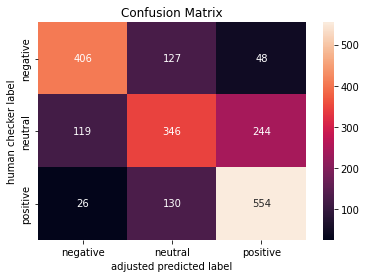

In [ ]:
con_matrix = confusion_matrix(sampled['human checker'], sampled['adjusted_pred'])
fig, ax = plt.subplots()
sns.heatmap(con_matrix, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'], 
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('adjusted predicted label')
plt.ylabel('human checker label')
plt.title("Confusion Matrix")

In [ ]:
# using grid search to find best set of threshold_a and threshold_b
# criteria: mattews_corrcoef
threshold_lst = []
for i in tqdm(range(51, 100)):
  threshold_a = i/100
  for j in range(51, 100):
    threshold_b = j/100
    adjusted_pred_labels = convert_labels(sampled, threshold_a, threshold_b)
    score = matthews_corrcoef(sampled['human checker'], adjusted_pred_labels)
    threshold_lst.append((score, threshold_a, threshold_b))
max(threshold_lst)

100%|██████████| 49/49 [04:00<00:00,  4.92s/it]


(0.482285513025065, 0.95, 0.79)

In [ ]:
heapq.nlargest(10, threshold_lst)

[(0.482285513025065, 0.95, 0.79),
 (0.48133805637189436, 0.95, 0.78),
 (0.4794174366126017, 0.95, 0.8),
 (0.4793400594488218, 0.84, 0.79),
 (0.478990084581744, 0.84, 0.78),
 (0.4788302419995251, 0.82, 0.79),
 (0.4785179918846526, 0.82, 0.78),
 (0.47847573811175725, 0.83, 0.79),
 (0.47842332456293873, 0.81, 0.79),
 (0.4781920637128623, 0.95, 0.77)]

0.95 is a very high threshold, and it would tend to overestimate the number of neutral comments. As there's not significant difference between (0.95, 0.79) and (0.84, 0.79), we choose 0.84 as threshold_a and 0.79 as threshold_b. This setting makes more sense in terms of inner validity, as the model was trained on a sampled balanced dataset. 

## Get all labeled comments

get labels/scores for training set 

In [ ]:
train_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/30200-balanced/train_data_bert_all.csv')

In [ ]:
y_label, scores = sentiment_analysis(train_comments)

100%|██████████| 1160798/1160798 [18:05:42<00:00, 17.82it/s]


In [ ]:
train_comments['pred_label'] = y_label
train_comments['pred_score'] = scores

In [ ]:
file_train_pred = '/content/drive/MyDrive/Colab Notebooks/30200-balanced/train_data_bert_all_pred.csv'
write_csv_2(train_comments, file_train_pred)

1160798it [01:37, 11872.49it/s]


Get labels for eval set

In [ ]:
eval_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/30200-balanced/eval_data_bert_all.csv')

In [ ]:
# check empty content
long_lst = []
for index, row in tqdm(eval_comments.iterrows()):
    if len(row['content'].strip()) >=512:
        long_lst.append(index)
long_lst

497486it [00:22, 21682.38it/s]


[38512,
 138881,
 151576,
 169273,
 176114,
 289628,
 290505,
 312945,
 319615,
 391497,
 398901]

In [ ]:
eval_comments.drop(long_lst, axis=0, inplace=True)
eval_comments = eval_comments.reset_index(drop=True)
eval_comments

,index,comment_time,movie_id,rating,content,user_md5,votes,label
0,0,2018-07-25 20:26:57,26578007,4.0,结尾牛逼。。,152733c1d5ff65ef66e3eea596975ed7,0,1
1,1,2019-08-07 23:57:50,27010768,4.0,匠气,3f57605dcdd7f382b03f5a4ae550ce68,15,1
2,2,2016-11-09 14:27:52,26877912,1.0,辣眼睛,83b84c8a0827d5524b60d98712408911,1,0
3,3,2008-03-25 13:36:23,1308245,5.0,儿时记忆啊,ac78cc42b03496ce2c3fd86bfe75ed22,1,1
4,4,2009-09-17 11:09:49,2042219,4.0,喜歡sachiko的西瓜汁，及素夜亲吻了黑板，又一個日本鄉村老套卻不能自拔的片,19cf3dc9ec62ae741531d9a6b9abc124,0,1
...,...,...,...,...,...,...,...,...
497470,497481,2019-07-28 13:33:31,30390144,4.0,The Farewell | 别告诉她\n\n导演Lulu Wang自己真实的家庭故事改编，...,53b7ba4f3b3cb355e52bbbb345ac38f5,5,1
497471,497482,2018-03-11 16:50:56,1401620,4.0,骇人听闻的无因的愤怒。让.维果、英国自由电影，甚至整个超现实主义运动都影响了马可。,c1cd625f5f55cd14f74ddf2a60e3fe0b,1,1
497472,497483,2012-01-03 17:29:33,1297200,4.0,很酷的一部蓝调音乐电影，竟然有雷·查尔斯在里面跑龙套……,6726644fa7df034da28485ec0f976781,0,1
497473,497484,2016-12-30 21:07:52,6796158,1.0,同样的配置同样的题材范冰冰就吊打刘亦菲了。毕竟她是得过国际影后的人。刘亦菲是怎么了？越长越男...,2682b3fbf6e3110dc0faa44c09dc354f,18,0


In [ ]:
y_label, scores = sentiment_analysis(eval_comments)

100%|██████████| 497475/497475 [7:54:05<00:00, 17.49it/s]


In [ ]:
eval_comments['pred_label'] = y_label
eval_comments['pred_score'] = scores

In [ ]:
file_eval_pred = '/content/drive/MyDrive/Colab Notebooks/30200-balanced/eval_data_bert_all_pred.csv'
write_csv_2(eval_comments, file_eval_pred)

46118it [00:04, 12217.47it/s]

Concatencate and get calibrated labels

In [ ]:
train_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/30200-balanced/train_data_bert_all_pred.csv')
test_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/30200-balanced/test_data_bert_pred.csv')
eval_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/30200-balanced/eval_data_bert_all_pred.csv')
pred_1_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/30200-balanced/prediction_data_predicted_1.csv')
pred_2_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/30200-balanced/prediction_data_predicted_2.csv')

In [ ]:
comments = pd.concat([train_comments, test_comments, eval_comments, pred_1_comments, pred_2_comments], axis=0)
del comments['index']
comments = comments.reset_index(drop=True)
comments

,comment_time,movie_id,rating,content,user_md5,votes,label,pred_label,pred_score
0,2017-07-19 22:29:00,2159056,5.0,2000美金和7根金条引发的一系列故事， 剧本、演技、笑点都没得挑。快70年的本子在现在看也...,1a4cbbfeed1f2d76e8c19224ef6c2282,0,1,1,0.980043
1,2013-05-15 10:58:32,1769479,2.0,看得想睡觉,4992f4704434191dfce5e3c3dc86e310,0,0,0,0.991495
2,2017-03-15 00:32:13,3557399,5.0,试着包容，美好就在眼前,24f0c83bbce8ae51189a7a653d231b45,0,1,1,0.938405
3,2009-10-15 23:21:38,4086809,2.0,woshibeibide,ae112cfe51097f4c8f7755f6479b593d,0,0,1,0.743563
4,2012-01-13 01:30:26,6038028,4.0,清新的风格,c31ead26a00cb283120200c4dbafa0ea,0,1,1,0.936623
...,...,...,...,...,...,...,...,...,...
4428447,2019-08-20 09:43:14,26879060,3.0,补，3.5,5e33fb5ffbc351ceab736fa544145c1b,0,-1,1,0.995120
4428448,2018-01-08 12:53:00,26914297,3.0,也许是对西贡小姐期望太高 远没有想象中那么好看~,7f9ff56797c67ae78f7ab1cd833f2bf3,0,-1,1,0.538686
4428449,2017-02-20 17:02:56,26914297,3.0,"the engineer, the nightclub pimp",f2a3e19b82eff98dfc3718b62b9aff75,0,-1,1,0.964866
4428450,2018-12-10 20:09:20,26914297,3.0,记不住里面任何一首歌，就觉得胖女孩的胳膊记忆犹新,4f696ad30cec6601ca49dfc2281985f3,0,-1,1,0.845171


In [ ]:
def convert_labels(exmaple_df, threshold_a, threshold_b):
  '''
  change predited label type according to the threshold. 
  if predicted label == 1 adn if the predicted score is lower than threshold_a, then convert label to 0.
  if predicted label == 0 adn if the predicted score is lower than threshold_a, then convert label to 0.
  Otherwise, convert label to 1 if original label is 1, convert to -1 if orginal label is 0
  '''
  adjusted_pred_labels = []
  for idx, row in tqdm(exmaple_df.iterrows()):
    if row['pred_label'] == 1.0:
      if row['pred_score'] <= threshold_a:
        adjusted_pred_labels.append(0)
      else:
        adjusted_pred_labels.append(1)
    else:
       if row['pred_score'] <= threshold_b:
         adjusted_pred_labels.append(0)
       else:
         adjusted_pred_labels.append(-1)
  return adjusted_pred_labels

In [ ]:
comments['adjusted_pred'] = convert_labels(comments, 0.84, 0.79)

4428452it [03:50, 19223.14it/s]


In [ ]:
# we don't use to_csv() here is because simply use to_csv() would yield 
# wrongly formatted csv files.
def write_csv_3(example_df, file_dir):
  '''
  write example DataFrame into the given file directory 
  '''
  with open(file_dir, 'w') as f:
    writer = csv.writer(f, delimiter=',')
    # write column names 
    writer.writerow(('index',
                     'comment_time',
                     'movie_id',
                     'rating',
                     'content',
                     'user_md5',
                     'votes',
                     'label',
                     'pred_label',
                     'pred_score',
                     'adjusted_pred'))
    for idx, row in tqdm(example_df.iterrows()):
            writer.writerow((idx,
                             row['comment_time'],
                             row['movie_id'],
                             row['rating'],
                             row['content'],
                             row['user_md5'],
                             row['votes'],
                             row['label'],
                             row['pred_label'],
                             row['pred_score'],
                             row['adjusted_pred']))

In [ ]:
comments['comment_time'] = pd.to_datetime(comments['comment_time'])
comments = comments.set_index('comment_time').sort_index()
comments = comments.reset_index()
file_dir = '/content/drive/MyDrive/Colab Notebooks/30200-balanced/all_comments_with_pred.csv'
write_csv_3(comments, file_dir)

4428452it [07:31, 9801.71it/s] 
